**Code-level function descriptions are present :)**
Suggestion: Maybe once you're done finalizing the code, can add a brief description of what you're trying to achieve prior to each code chunk. Would be great if can also add a description of what each output tells us. That way the marker can follow the flow of the work more intuitively.

In [ ]:
import random
import simpy
import os
import numpy as np
import pandas as pd
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import solara
import random
import matplotlib.pyplot as plt

# SimPy Queue System


In [83]:
np.random.seed(50)
#self.unqiue_id = unique_id

##start
# Guest Agent (Moves on Grid Toward a Ride)
class GuestAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.destination = None
        self.attraction = None
        self.arrival_time = 0
        self.ride_completion_time = 0
        self.last_ride = None
        self.time_to_leave = random.randint(360, 540)
        self.leaving = False
        self.failed_attempts = 0  # Track failed ride attempts
        self.rides_completed = 0  # Track rides completed

    def step(self):
        if self.leaving:
            if self.pos == self.model.start_pos:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                self.model.guests_left += 1
                #print(f"Guest {self.unique_id} left the park")
            else:
                self.move_toward_destination(self.model.start_pos)
            return

        if self.ride_completion_time > 0:
            self.ride_completion_time -= 1
            if self.ride_completion_time == 0:
                #print(f"Guest {self.unique_id} finished riding {self.attraction.name}")
                self.rides_completed += 1  # Increment rides completed
                self.destination = None
            return

        if not self.destination:
            self.choose_ride()

        if self.destination:
            self.move_toward_destination(self.destination)

            if self.pos == self.destination:
                self.arrive_at_ride()

        self.time_to_leave -= 1
        if self.time_to_leave <= 0 and not self.leaving:
            self.leaving = True
            self.destination = self.model.start_pos
            #print(f"Guest {self.unique_id} decided to leave the park")

    def arrive_at_ride(self):
        if len(self.attraction.queue.queue) < self.attraction.capacity * 3:
            self.attraction.env.process(self.attraction.ride_experience(self))
            #print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
            self.last_ride = self.attraction
        else:
            #print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
            self.failed_attempts += 1  # Increment failed attempts
            self.destination = None

    def choose_ride(self):
        """Choose a ride based on popularity and queue length, excluding the last ride."""
        if not self.model.rides:
            return

        # Exclude the last ride from the selection
        available_rides = [ride for ride in self.model.rides if ride != self.last_ride]

        if not available_rides:
            return  # No available rides

        # Weighted ride selection: 1/popularity_rank
        ride_weights = [1 / ride.popularity_rank for ride in available_rides]
        self.attraction = random.choices(available_rides, weights=ride_weights, k=1)[0]
        self.destination = self.attraction.pos
        #print(f"Guest {self.unique_id} chose {self.attraction.name} at {self.destination}")

    def move_toward_destination(self, destination):
        """Move one step toward the destination, avoiding restricted areas."""
        x, y = self.pos
        dx, dy = destination

        # Calculate possible new positions
        possible_moves = []
        for new_x, new_y in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
            if not self.model.is_restricted(new_x, new_y) and not self.model.grid.out_of_bounds((new_x, new_y)):
                possible_moves.append((new_x, new_y))

        if possible_moves:
            # Choose the move that minimizes distance to the destination
            best_move = min(possible_moves, key=lambda pos: abs(pos[0] - dx) + abs(pos[1] - dy))
            self.model.grid.move_agent(self, best_move)
            #print(f"Guest {self.unique_id} moved from {self.pos} to {best_move}")


# Ride Agent (Fixed in Place)
class RideAgent(Agent):
    def __init__(self, unique_id, model, name, pos, capacity, service_time, popularity_rank):
        super().__init__(model)
        self.unique_id = unique_id
        self.name = name
        self.pos = pos
        self.capacity = capacity
        self.service_time = service_time  # Number of steps to complete one ride cycle
        self.popularity_rank = popularity_rank
        self.env = simpy.Environment()  # Simpy environment for queue management
        self.queue = simpy.Resource(self.env, capacity=capacity)
        self.queue_lengths = []  # Track queue lengths over time
        self.wait_times = []  # Track guest wait times

    def ride_experience(self, guest):
        """Simulate the ride experience using Simpy."""
        with self.queue.request() as request:
            queue_length = len(self.queue.queue)
            self.queue_lengths.append(queue_length)  # Track queue length

            yield request  # Wait for turn
            wait_time = self.env.now - guest.arrival_time
            self.wait_times.append(wait_time)

            yield self.env.timeout(self.service_time)  # Ride duration
            guest.ride_completion_time = self.service_time  # Set ride completion time
            #print(f"Guest {guest.unique_id} waited {wait_time:.2f} mins and started riding {self.name}")

# Theme Park Model (Grid-Based)
class ThemeParkGridModel(Model):
    def __init__(self, width, height, restricted_bottom_left=None, restricted_top_right=None, guest_inflow_type = None):
        super().__init__()  # Correctly initialize the Model
        self.grid = MultiGrid(width, height, True)  # Initialize grid first
        self.schedule = RandomActivation(self)
        self.randomizer = random  # Use built-in Python random
        if restricted_bottom_left is not None and restricted_top_right is not None:
            # Generate all coordinates in the rectangle defined by bottom-left and top-right
            x_min, y_min = restricted_bottom_left
            x_max, y_max = restricted_top_right
            self.restricted_area = [(x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]
        else:
            # Default restricted area (if not provided)
            self.restricted_area = None  # Restricted area in the center
        self.start_pos = (width // 2, 0)  # Bottom center for ingress/egress
        self.guests_entered = 0  # Track guests entering the park
        self.guests_left = 0  # Track guests leaving the park
        self.rides = []
        self.guest_inflow_type = guest_inflow_type
    
        for ride in self.rides:
            self.schedule.add(ride)
            self.grid.place_agent(ride, ride.pos)
        
    def add_ride(self, name, pos, capacity, service_time, popularity_rank):
        # """Add a new ride to the theme park."""
        ride_id = len(self.rides) + 1  # Assign a unique ID
        new_ride = RideAgent(ride_id, self, name, pos, capacity, service_time, popularity_rank)
        self.rides.append(new_ride)
        self.schedule.add(new_ride)
        self.grid.place_agent(new_ride, pos)
        #print(f"Added new ride: {name} at {pos}")


    def is_restricted(self, x, y):
        """Check if a position is in the restricted area."""
        if self.restricted_area is None:
            return False
        return (x, y) in self.restricted_area
    

    def step(self, guest_inflow_type=None):
        """Advance the model by one step.
        
        Args:
            steps: Optional step counter (not needed for Mesa's built-in stepping)
        """
        # Handle guest inflow
        if self.guest_inflow_type is not None:
            # Get guest count from dataset for current step
            try:
                current_step = self.schedule.steps  # Use Mesa's internal step counter
                new_guests_count = self.guest_inflow_type.iloc[current_step]['GuestCount']
            except (IndexError, KeyError):
                # Fallback if step exceeds dataset or column not found
                new_guests_count = random.randint(100, 200)
        else:
            # Default random inflow
            new_guests_count = random.randint(100, 200)
        
        # Add new guests
        for _ in range(new_guests_count):
            # Get next available unique_id
            existing_ids = [agent.unique_id for agent in self.schedule.agents]
            new_guest_id = max(existing_ids) + 1 if existing_ids else 0
            
            new_guest = GuestAgent(new_guest_id, self)
            self.schedule.add(new_guest)
            self.grid.place_agent(new_guest, self.start_pos)
            self.guests_entered += 1

        # Advance simulation - let Mesa handle the step counting
        self.schedule.step()
        
        # Advance each ride's environment
        for ride in self.rides:
            ride.env.run(until=ride.env.now + 1)

        # Reset counter for next step
        self.guests_left = 0

# Function to plot heatmap and rides
def plot_combined_heatmap_and_rides_normalized(model):
    # Create a grid to count guest positions for the heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))

    # Count guest positions
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            heatmap[x][y] += 1

    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
    plt.colorbar(label="Normalized Guest Activity")

    # Plot each ride and annotate its name
    for ride in model.rides:
        x, y = ride.pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
        plt.text(x, y + 0.3, ride.name, fontsize=12, ha='center', color='white')  # Add ride name

    # Plot restricted area
    if model.restricted_area:
        for (x, y) in model.restricted_area:
            plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

    # Add grid lines and labels
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.title("Theme Park Heatmap with Rides", fontsize=16)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [ ]:
# np.random.seed(50)
# #self.unqiue_id = unique_id

# ##start
# # Guest Agent (Moves on Grid Toward a Ride)
# class GuestAgent(Agent):
#     def __init__(self, unique_id, model):
#         super().__init__(model)
#         self.unique_id = unique_id
#         self.destination = None
#         self.attraction = None
#         self.arrival_time = 0
#         self.ride_completion_time = 0
#         self.last_ride = None
#         self.time_to_leave = random.randint(20, 100)
#         self.leaving = False
#         self.failed_attempts = 0  # Track failed ride attempts
#         self.rides_completed = 0  # Track rides completed

#     def step(self):
#         if self.leaving:
#             if self.pos == self.model.start_pos:
#                 self.model.grid.remove_agent(self)
#                 self.model.schedule.remove(self)
#                 self.model.guests_left += 1
#                 #print(f"Guest {self.unique_id} left the park")
#             else:
#                 self.move_toward_destination(self.model.start_pos)
#             return

#         if self.ride_completion_time > 0:
#             self.ride_completion_time -= 1
#             if self.ride_completion_time == 0:
#                 #print(f"Guest {self.unique_id} finished riding {self.attraction.name}")
#                 self.rides_completed += 1  # Increment rides completed
#                 self.destination = None
#             return

#         if not self.destination:
#             self.choose_ride()

#         if self.destination:
#             self.move_toward_destination(self.destination)

#             if self.pos == self.destination:
#                 self.arrive_at_ride()

#         self.time_to_leave -= 1
#         if self.time_to_leave <= 0 and not self.leaving:
#             self.leaving = True
#             self.destination = self.model.start_pos
#             #print(f"Guest {self.unique_id} decided to leave the park")

#     def arrive_at_ride(self):
#         if len(self.attraction.queue.queue) < self.attraction.capacity * 3:
#             self.attraction.env.process(self.attraction.ride_experience(self))
#             #print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
#             self.last_ride = self.attraction
#         else:
#             #print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
#             self.failed_attempts += 1  # Increment failed attempts
#             self.destination = None

#     def choose_ride(self):
#         """Choose a ride based on popularity and queue length, excluding the last ride."""
#         if not self.model.rides:
#             return

#         # Exclude the last ride from the selection
#         available_rides = [ride for ride in self.model.rides if ride != self.last_ride]

#         if not available_rides:
#             return  # No available rides

#         # Weighted ride selection: 1/popularity_rank
#         ride_weights = [1 / ride.popularity_rank for ride in available_rides]
#         self.attraction = random.choices(available_rides, weights=ride_weights, k=1)[0]
#         self.destination = self.attraction.pos
#         #print(f"Guest {self.unique_id} chose {self.attraction.name} at {self.destination}")

#     def move_toward_destination(self, destination):
#         """Move one step toward the destination, avoiding restricted areas."""
#         x, y = self.pos
#         dx, dy = destination

#         # Calculate possible new positions
#         possible_moves = []
#         for new_x, new_y in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
#             if not self.model.is_restricted(new_x, new_y) and not self.model.grid.out_of_bounds((new_x, new_y)):
#                 possible_moves.append((new_x, new_y))

#         if possible_moves:
#             # Choose the move that minimizes distance to the destination
#             best_move = min(possible_moves, key=lambda pos: abs(pos[0] - dx) + abs(pos[1] - dy))
#             self.model.grid.move_agent(self, best_move)
#             #print(f"Guest {self.unique_id} moved from {self.pos} to {best_move}")

#     # def arrive_at_ride(self):
#     #     """Handle guest arrival at the ride."""
#     #     if len(self.attraction.queue.queue) < self.attraction.capacity * 3:  # Join queue if not too long
#     #         self.attraction.env.process(self.attraction.ride_experience(self))
#     #         print(f"Guest {self.unique_id} joined the queue at {self.attraction.name}")
#     #         self.last_ride = self.attraction  # Update last ride visited
#     #     else:
#     #         print(f"Guest {self.unique_id} left {self.attraction.name} due to long queue")
#     #         self.destination = None  # Choose a new ride next step

# # Ride Agent (Fixed in Place)
# class RideAgent(Agent):
#     def __init__(self, unique_id, model, name, pos, capacity, service_time, popularity_rank):
#         super().__init__(model)
#         self.unique_id = unique_id
#         self.name = name
#         self.pos = pos
#         self.capacity = capacity
#         self.service_time = service_time  # Number of steps to complete one ride cycle
#         self.popularity_rank = popularity_rank
#         self.env = simpy.Environment()  # Simpy environment for queue management
#         self.queue = simpy.Resource(self.env, capacity=capacity)
#         self.queue_lengths = []  # Track queue lengths over time
#         self.wait_times = []  # Track guest wait times

#     def ride_experience(self, guest):
#         """Simulate the ride experience using Simpy."""
#         with self.queue.request() as request:
#             queue_length = len(self.queue.queue)
#             self.queue_lengths.append(queue_length)  # Track queue length

#             yield request  # Wait for turn
#             wait_time = self.env.now - guest.arrival_time
#             self.wait_times.append(wait_time)

#             yield self.env.timeout(self.service_time)  # Ride duration
#             guest.ride_completion_time = self.service_time  # Set ride completion time
#             #print(f"Guest {guest.unique_id} waited {wait_time:.2f} mins and started riding {self.name}")

# # Theme Park Model (Grid-Based)
# class ThemeParkGridModel(Model):
#     def __init__(self, width, height, num_guests):
#         super().__init__()  # Correctly initialize the Model
#         self.grid = MultiGrid(width, height, True)  # Initialize grid first
#         self.schedule = RandomActivation(self)
#         self.randomizer = random  # Use built-in Python random
#         self.restricted_area = [(x, y) for x in range(2, 4) for y in range(2, 6)]  # Restricted area in the center
#         self.start_pos = (width // 2, 0)  # Bottom center for ingress/egress
#         self.guests_entered = 0  # Track guests entering the park
#         self.guests_left = 0  # Track guests leaving the park
#         self.rides = []
#         # Add rides with popularity ranking
#         # self.rides = [
#         #     RideAgent(1, self, "Roller Coaster", (1, 1), 5, 10, 1),  # Bottom left
#         #     RideAgent(2, self, "Ferris Wheel", (2, 8), 5, 15, 3),      # Middle top
#         #     RideAgent(3, self, "Haunted House", (8, 3), 5, 20, 2),     # Middle right
#         #     RideAgent(4, self, "Bumper Cars", (6, 6), 5, 10, 4),       # Center
#         #     RideAgent(5, self, "Drop Tower", (8, 8), 5, 15, 2),        # Top right, second most popular
#         # ]
#         for ride in self.rides:
#             self.schedule.add(ride)
#             self.grid.place_agent(ride, ride.pos)
        
#     def add_ride(self, name, pos, capacity, service_time, popularity_rank):
#         # """Add a new ride to the theme park."""
#         ride_id = len(self.rides) + 1  # Assign a unique ID
#         new_ride = RideAgent(ride_id, self, name, pos, capacity, service_time, popularity_rank)
#         self.rides.append(new_ride)
#         self.schedule.add(new_ride)
#         self.grid.place_agent(new_ride, pos)
#         #print(f"Added new ride: {name} at {pos}")

#         #Add initial guests at the bottom center of the grid
#         # for i in range(num_guests):
#         #     guest = GuestAgent(i + 10, self)
#         #     self.schedule.add(guest)
#         #     self.grid.place_agent(guest, self.start_pos)

#     def is_restricted(self, x, y):
#         """Check if a position is in the restricted area."""
#         return (x, y) in self.restricted_area

#     def step(self):
#         # Ingress: Add a random number of new guests (100 to 200) at the bottom center
#         new_guests_count = random.randint(100, 200)
#         for i in range(new_guests_count):
#             new_guest_id = max(agent.unique_id for agent in self.schedule.agents) + 1
#             new_guest = GuestAgent(new_guest_id, self)
#             self.schedule.add(new_guest)
#             self.grid.place_agent(new_guest, self.start_pos)
#             self.guests_entered += 1  # Track guests entering the park

#         # Advance the simulation
#         self.schedule.step()
#         for ride in self.rides:
#             ride.env.run(until=ride.env.now + 1)

#         # Print ingress and egress messages
#         #print(f"Step {self.schedule.steps}: {new_guests_count} guests entered the park, {self.guests_left} guests left the park")
#         self.guests_left = 0  # Reset guests_left counter for the next step

# # Function to plot heatmap and rides
# def plot_combined_heatmap_and_rides_normalized(model):
#     # Create a grid to count guest positions for the heatmap
#     heatmap = np.zeros((model.grid.width, model.grid.height))

#     # Count guest positions
#     for agent in model.schedule.agents:
#         if isinstance(agent, GuestAgent):
#             x, y = agent.pos
#             heatmap[x][y] += 1

#     # Normalize the heatmap
#     if np.max(heatmap) > 0:
#         heatmap = heatmap / np.max(heatmap)

#     # Plot the heatmap
#     plt.figure(figsize=(8, 8))
#     plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
#     plt.colorbar(label="Normalized Guest Activity")

#     # Plot each ride and annotate its name
#     for ride in model.rides:
#         x, y = ride.pos
#         plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
#         plt.text(x, y + 0.3, ride.name, fontsize=12, ha='center', color='white')  # Add ride name

#     # Plot restricted area
#     for (x, y) in model.restricted_area:
#         plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

#     # Add grid lines and labels
#     plt.xticks(range(model.grid.width))
#     plt.yticks(range(model.grid.height))
#     plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
#     plt.title("Theme Park Heatmap with Rides", fontsize=16)
#     plt.xlabel("X Coordinate")
#     plt.ylabel("Y Coordinate")
#     plt.show()

In [4]:
#Read in data
dir_path = r'C:\Users\User\Downloads\DSA3101_Dataset'  # or unix / linux / mac path
os.chdir(dir_path)
# Get the files from the path provided in the OP
dataframes = {}

for file in os.listdir():
    if file.endswith('.csv'):
        name = file.replace('.csv', '')  # Get the base name without .csv
        dataframes[name] = pd.read_csv(file)  # Store the dataframe with its name as the key



In [5]:
#Reading and editting the dataframes

dataframes
attendance = dataframes.get('attendance')
waiting_times = dataframes.get('waiting_times')
waiting_times
ranking =  waiting_times.groupby('ENTITY_DESCRIPTION_SHORT').agg({
    'GUEST_CARRIED': 'sum',
    'CAPACITY': 'mean'
}).sort_values('GUEST_CARRIED', ascending=False)
ranking

link_attraction_park = dataframes.get('link_attraction_park')
link_attraction_park[['Attraction', 'Park']] = link_attraction_park['ATTRACTION;PARK'].str.split(';', n=1, expand=True)
link_attraction_park


,ATTRACTION;PARK,Attraction,Park
0,Aeroplane Ride;Tivoli Gardens,Aeroplane Ride,Tivoli Gardens
1,Bumper Cars;PortAventura World,Bumper Cars,PortAventura World
2,Bungee Jump;PortAventura World,Bungee Jump,PortAventura World
3,Circus Train;PortAventura World,Circus Train,PortAventura World
4,Crazy Bus;Tivoli Gardens,Crazy Bus,Tivoli Gardens
5,Crazy Dance;PortAventura World,Crazy Dance,PortAventura World
6,Dizzy Dropper;PortAventura World,Dizzy Dropper,PortAventura World
7,Drop Tower;PortAventura World,Drop Tower,PortAventura World
8,Flying Coaster;PortAventura World,Flying Coaster,PortAventura World
9,Free Fall;PortAventura World,Free Fall,PortAventura World


In [6]:
attraction_ranking = ranking.join(link_attraction_park.set_index('Attraction'), on='ENTITY_DESCRIPTION_SHORT')
tivoli_attr_ranking = attraction_ranking[(attraction_ranking['Park'] == 'Tivoli Gardens')]
tivoli_attr_ranking['Ranking'] = range(1, len(tivoli_attr_ranking) + 1)
#tivoli_attr_ranking = tivoli_attr_ranking[['Park', 'Ranking']]
PortAventura_attr_ranking = attraction_ranking[(attraction_ranking['Park'] == 'PortAventura World')]
PortAventura_attr_ranking['Ranking'] = range(1, len(PortAventura_attr_ranking) + 1)
#PortAventura_attr_ranking = PortAventura_attr_ranking[['Park', 'Ranking']]

C:\Users\User\AppData\Local\Temp\ipykernel_31624\1964251836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_attr_ranking['Ranking'] = range(1, len(tivoli_attr_ranking) + 1)
C:\Users\User\AppData\Local\Temp\ipykernel_31624\1964251836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PortAventura_attr_ranking['Ranking'] = range(1, len(PortAventura_attr_ranking) + 1)


In [ ]:
# #Inserting data get the average
# park1 = simpy.Environment()
# tivoli_park = ThemeParkModel(park1)
# for _, row in tivoli_attr_ranking.iterrows():
#     # Assuming Ride requires (env, capacity, duration, rank)
#     attraction = Ride(park1, row['CAPACITY'], 15, row['Ranking'])
#     tivoli_park.add_ride(attraction)

# park2 = simpy.Environment()
# PortAventura = ThemeParkModel(park2)
# for _, row in PortAventura_attr_ranking.iterrows():
#     # Assuming Ride requires (env, capacity, duration, rank)
#     attraction = Ride(park1, row['CAPACITY'], 15, row['Ranking'])
#     PortAventura.add_ride(attraction)



C:\Users\User\AppData\Local\Temp\ipykernel_31624\3405484052.py:142: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\User\anaconda3\envs\yuan\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0
Failed attempts: 2764, Rides per guest: 1051, total_guests: 4729
Density score: 58.382716049382715, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1829.7654320987654
Failed attempts: 3298, Rides per guest: 1688, total_guests: 5054
Density score: 62.39506172839506, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1734.79012345679
Failed attempts: 2226, Rides per guest: 763, total_guests: 5063
Density score: 62.50617283950617, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1588.0123456790122
Failed attempts: 2151, Rides per guest: 965, total_guests: 4788
Density score: 59.111111111111114, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1304.2222222222222
Failed attempts: 1814, Rides per guest: 828, total_guests: 4718
Density score: 58.24691358024691, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1102.4938271604938
Generation 1
Failed attempts: 1725, Rides per guest: 765, total_guests: 5045
Density score: 62.28395061728395, Popularity Pen

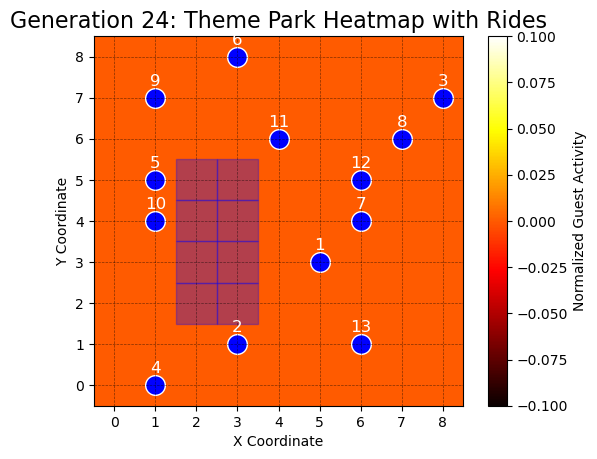

Best ride positions: [(11, (6, 5)), (8, (1, 7)), (3, (1, 0)), (4, (1, 5)), (10, (4, 6)), (0, (5, 3)), (1, (3, 1)), (2, (8, 7)), (12, (6, 1)), (7, (7, 6)), (6, (6, 4)), (9, (1, 4)), (5, (3, 8))]


In [ ]:
# from deap import base, creator, tools, algorithms
# import random
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# # Define the fitness function
# def fitness_function(individual, model, possible_rides):
#     """Calculate the fitness of a ride placement configuration."""
#     # Reset the model for this individual
#     reset_model(model, possible_rides, individual)

#     total_failed_attempts = 0
#     total_rides_per_guest = 0
#     grid_density = np.zeros((model.grid.width, model.grid.height))
#     restricted_penalty = 0  # Penalty for rides in restricted areas
#     popular_ride_penalty = 0  # Penalty for popular rides placed too close
#     total_guests = 0
#     # Extract ride positions and selected rides from the individual
#     ride_positions = [pos for _, pos in individual]
#     selected_rides = [possible_rides[ride_idx] for ride_idx, _ in individual]

#     # Check if any ride is in a restricted area
#     for pos in ride_positions:
#         if model.is_restricted(*pos):  # Check if position is restricted
#             restricted_penalty -= 1000  # Apply a large penalty

#     # Calculate distance between popular rides
#     popular_ride_positions = []
#     for i, pos in enumerate(ride_positions):
#         ride = selected_rides[i]
#         if ride['popularity_rank'] <= len(ride)/3:  # Define popular rides as those with rank <= 2
#             popular_ride_positions.append(pos)

#     # Calculate pairwise distances between popular rides
#     for i in range(len(popular_ride_positions)):
#         for j in range(i + 1, len(popular_ride_positions)):
#             x1, y1 = popular_ride_positions[i]
#             x2, y2 = popular_ride_positions[j]
#             distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)  # Euclidean distance
#             if distance < 5:  # Threshold for spacing (adjust as needed)
#                 popular_ride_penalty -= (5 - distance) * 100  # Penalize based on closeness
    
#     # Add a fixed number of guests for this evaluation
#     num_guests = 1000
#     for i in range(num_guests):
#         guest = GuestAgent(i, model)
#         model.schedule.add(guest)
#         model.grid.place_agent(guest, model.start_pos)

#     # Initialize variables for fitness calculation

#     # Simulate guest behavior for this ride configuration
#     for step in range(26):  # Simulate 26 steps by right 50
#         model.step()  # Advance the entire simulation by one step

#         # Track guest positions at the 25th step
#         if step == 25:
#             for guest in model.schedule.agents:
#                 if isinstance(guest, GuestAgent):
#                     x, y = guest.pos
#                     if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
#                         grid_density[x][y] += 1

#     # Track failed ride attempts and rides completed
#     for guest in model.schedule.agents:
#         if isinstance(guest, GuestAgent):
#             total_failed_attempts += guest.failed_attempts
#             total_rides_per_guest += guest.rides_completed
#             total_guests += 1

#     # Calculate density score (average density at the 25th step)
#     density_score = np.sum(grid_density) / (model.grid.width * model.grid.height)

#     # Combine objectives into a single fitness score
#     satisfaction_score = -total_failed_attempts  # Minimize failed attempts
#     rides_score = total_rides_per_guest  # Maximize rides per guest
#     fitness = satisfaction_score + rides_score - density_score * 2 + restricted_penalty + popular_ride_penalty

#     # Debug: Print intermediate results
#     print(f"Failed attempts: {total_failed_attempts}, Rides per guest: {total_rides_per_guest}, total_guests: {total_guests}")
#     print(f"Density score: {density_score}, Popularity Penalty: {popular_ride_penalty}, restricted_penalty: {restricted_penalty}")
#     print(f"Fitness: {fitness}")

#     # Remove guests after evaluation
#     for guest in list(model.schedule.agents):
#         if isinstance(guest, GuestAgent):
#             model.schedule.remove(guest)
#             model.grid.remove_agent(guest)

#     return (fitness,)

# # Function to generate a valid position (not in restricted area and not occupied by another ride)
# def generate_valid_position(model):
#     while True:
#         pos = (random.randint(0, model.grid.width - 1), random.randint(0, model.grid.height - 1))
#         if not model.is_restricted(*pos):  # Ensure position is not restricted
#             return pos

# # Function to ensure uniqueness of ride indices in an individual
# def ensure_unique_rides(individual, possible_rides):
#     """Ensure that an individual has no duplicate ride indices."""
#     ride_indices = [ride_idx for ride_idx, _ in individual]
#     unique_ride_indices = list(set(ride_indices))  # Remove duplicates
#     if len(unique_ride_indices) < len(ride_indices):
#         # If duplicates exist, replace them with unique ride indices
#         available_rides = set(range(len(possible_rides))) - set(unique_ride_indices)
#         for i in range(len(ride_indices)):
#             if ride_indices[i] in unique_ride_indices:
#                 unique_ride_indices.remove(ride_indices[i])
#             else:
#                 # Replace duplicate with a unique ride index
#                 ride_indices[i] = available_rides.pop()
#         # Update the individual with unique ride indices
#         individual = [(ride_indices[i], pos) for i, (_, pos) in enumerate(individual)]
#     return individual

# # Function to ensure uniqueness of positions in an individual
# def ensure_unique_positions(individual, model):
#     """Ensure that an individual has no duplicate positions."""
#     positions = [pos for _, pos in individual]
#     unique_positions = list(set(positions))  # Remove duplicates
#     if len(unique_positions) < len(positions):
#         # If duplicates exist, replace them with unique positions
#         for i in range(len(positions)):
#             if positions[i] in unique_positions:
#                 unique_positions.remove(positions[i])
#             else:
#                 # Replace duplicate with a unique position
#                 positions[i] = generate_valid_position(model)
#         # Update the individual with unique positions
#         individual = [(ride_idx, positions[i]) for i, (ride_idx, _) in enumerate(individual)]
#     return individual

# # Function to repair the best individual
# def repair_individual(individual, possible_rides, model):
#     """Repair an individual by replacing duplicate ride indices and positions with unique ones."""
#     individual = ensure_unique_rides(individual, possible_rides)
#     individual = ensure_unique_positions(individual, model)
#     return individual

# # Function to reset the model for each individual
# def reset_model(model, possible_rides, individual):
#     """Reset the model and add rides based on the current individual."""
#     # Clear existing rides
#     for agent in list(model.schedule.agents):
#         if isinstance(agent, RideAgent):
#             model.schedule.remove(agent)
#             model.grid.remove_agent(agent)

#     # Add rides from the current individual
#     for ride_idx, pos in individual:
#         ride = possible_rides[ride_idx]
#         model.add_ride(
#             name=ride['name'],
#             pos=pos,
#             capacity=ride['capacity'],
#             service_time=ride['service_time'],
#             popularity_rank=ride['popularity_rank']
#         )

# # Function to plot the current best solution
# def plot_best_solution(best_individual, model, possible_rides, generation):
#     """Plot the current best ride placements."""
#     # Clear the previous plot
#     plt.clf()

#     # Create a grid to count guest positions for the heatmap
#     heatmap = np.zeros((model.grid.width, model.grid.height))

#     # Count guest positions
#     for agent in model.schedule.agents:
#         if isinstance(agent, GuestAgent):
#             x, y = agent.pos
#             heatmap[x][y] += 1

#     # Normalize the heatmap
#     if np.max(heatmap) > 0:
#         heatmap = heatmap / np.max(heatmap)

#     # Plot the heatmap
#     plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
#     plt.colorbar(label="Normalized Guest Activity")

#     # Plot each ride and annotate its name
#     for ride_idx, pos in best_individual:
#         ride = possible_rides[ride_idx]
#         x, y = pos
#         plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
#         plt.text(x, y + 0.3, ride['name'], fontsize=12, ha='center', color='white')  # Add ride name

#     # Plot restricted area
#     for (x, y) in model.restricted_area:
#         plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

#     # Add grid lines and labels
#     plt.xticks(range(model.grid.width))
#     plt.yticks(range(model.grid.height))
#     plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
#     plt.title(f"Generation {generation}: Theme Park Heatmap with Rides", fontsize=16)
#     plt.xlabel("X Coordinate")
#     plt.ylabel("Y Coordinate")
#     plt.show()

# # Function to set up and run the Genetic Algorithm
# def optimize_ride_placement(model, possible_rides, num_rides):
#     # Set up DEAP for Genetic Algorithm
#     creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#     creator.create("Individual", list, fitness=creator.FitnessMax)

#     toolbox = base.Toolbox()
#     # Define an attribute for a ride-position pair
#     toolbox.register("attr_ride_pos", lambda: (random.randint(0, len(possible_rides) - 1), generate_valid_position(model)))
#     toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_ride_pos, n=num_rides)
#     toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#     def evaluate(individual):
#         return fitness_function(individual, model, possible_rides)

#     # Define custom mutation function to handle tuples and avoid restricted areas
#     def mutate_individual(individual, indpb, model):
#         for i in range(len(individual)):
#             if random.random() < indpb:
#                 # Mutate the ride index or position
#                 if random.random() < 0.5:  # Mutate ride index
#                     individual[i] = (random.randint(0, len(possible_rides) - 1), individual[i][1])
#                 else:  # Mutate position
#                     individual[i] = (individual[i][0], generate_valid_position(model))
#         # Ensure uniqueness of ride indices and positions after mutation
#         individual = ensure_unique_rides(individual, possible_rides)
#         individual = ensure_unique_positions(individual, model)
#         return individual,

#     # Define custom crossover function to ensure unique positions
#     def cxTwoPointUnique(ind1, ind2, model):
#         """Perform a two-point crossover while ensuring unique positions."""
#         # Perform the standard two-point crossover
#         tools.cxTwoPoint(ind1, ind2)
#         # Ensure uniqueness of positions in both individuals
#         ind1[:] = ensure_unique_positions(ind1, model)
#         ind2[:] = ensure_unique_positions(ind2, model)
#         return ind1, ind2

#     toolbox.register("evaluate", evaluate)
#     toolbox.register("mate", cxTwoPointUnique, model=model)
#     toolbox.register("mutate", mutate_individual, indpb=0.1, model=model)
#     toolbox.register("select", tools.selTournament, tournsize=3)

#     # Initialize population
#     population = toolbox.population(n=5)
#     # Ensure uniqueness of ride indices and positions in the initial population
#     for ind in population:
#         ind[:] = ensure_unique_rides(ind, possible_rides)
#         ind[:] = ensure_unique_positions(ind, model)

#     # Run the GA in a loop
#     ngen = 25  # Number of generations
#     for generation in range(ngen):
#         print(f"Generation {generation}")

#         # Select the next generation
#         offspring = toolbox.select(population, len(population))
#         offspring = list(map(toolbox.clone, offspring))

#         # Apply crossover and mutation
#         for child1, child2 in zip(offspring[::2], offspring[1::2]):
#             if random.random() < 0.5:  # Crossover probability
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
#                 child1[:] = ensure_unique_rides(child1, possible_rides)
#                 child1[:] = ensure_unique_positions(child1, model)
#                 child2[:] = ensure_unique_rides(child2, possible_rides)
#                 child2[:] = ensure_unique_positions(child2, model)

#         for mutant in offspring:
#             if random.random() < 0.2:  # Mutation probability
#                 toolbox.mutate(mutant)
#                 del mutant.fitness.values

#         # Evaluate the new individuals
#         invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#         for ind, fit in zip(invalid_ind, fitnesses):
#             ind.fitness.values = fit

#         # Replace the population with the new generation
#         population[:] = offspring

#     # Get the best solution
#     best_individual = tools.selBest(population, k=1)[0]
#     # Repair the best individual to ensure no duplicates
#     best_individual = repair_individual(best_individual, possible_rides, model)
#     plot_best_solution(best_individual, model, possible_rides, generation)
#     #print("Best ride positions (after repair):", best_individual)
#     return best_individual
    

# # Initialize the theme park model
# tivoli_park = ThemeParkGridModel(width=9, height=9, num_guests=100)

# # Define possible rides (from DataFrame or other source)
# possible_rides = []

# # Add rides dynamically from the DataFrame
# for _, row in tivoli_attr_ranking.iterrows():
#     # Add the ride with parameters from the DataFrame
#     possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

# # Optimize ride placement
# num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park
# best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, num_rides)

# # Add the selected rides to the model
# for ride_idx, pos in best_ride_positions:
#     ride = possible_rides[ride_idx]
#     tivoli_park.add_ride(
#         name=ride['name'],
#         pos=pos,
#         capacity=ride['capacity'],
#         service_time=ride['service_time'],
#         popularity_rank=ride['popularity_rank']
#     )

# # Print the best ride positions
# print("Best ride positions:", best_ride_positions)

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Define the fitness function
def fitness_function(individual, model, possible_rides):
    """Calculate the fitness of a ride placement configuration."""
    # Reset the model for this individual
    reset_model(model, possible_rides, individual)

    total_failed_attempts = 0
    total_rides_per_guest = 0
    grid_density = np.zeros((model.grid.width, model.grid.height))
    restricted_penalty = 0  # Penalty for rides in restricted areas
    popular_ride_penalty = 0  # Penalty for popular rides placed too close
    total_guests = 0
    # Extract ride positions and selected rides from the individual
    ride_positions = [pos for _, pos in individual]
    selected_rides = [possible_rides[ride_idx] for ride_idx, _ in individual]

    # Check if any ride is in a restricted area
    for pos in ride_positions:
        if model.is_restricted(*pos):  # Check if position is restricted
            restricted_penalty -= 1000  # Apply a large penalty

    # Calculate distance between popular rides
    popular_ride_positions = []
    for i, pos in enumerate(ride_positions):
        ride = selected_rides[i]
        if ride['popularity_rank'] <= len(ride)/3:  # Define popular rides as those with rank <= 2
            popular_ride_positions.append(pos)

    # Calculate pairwise distances between popular rides
    for i in range(len(popular_ride_positions)):
        for j in range(i + 1, len(popular_ride_positions)):
            x1, y1 = popular_ride_positions[i]
            x2, y2 = popular_ride_positions[j]
            distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)  # Euclidean distance
            if distance < 5:  # Threshold for spacing (adjust as needed)
                popular_ride_penalty -= (5 - distance) * 100  # Penalize based on closeness
    
    # Add a fixed number of guests for this evaluation
    num_guests = 1000
    for i in range(num_guests):
        guest = GuestAgent(i, model)
        model.schedule.add(guest)
        model.grid.place_agent(guest, model.start_pos)

    # Initialize variables for fitness calculation

    # Simulate guest behavior for this ride configuration
    for step in range(361):  # Simulate 26 steps by right 50
        model.step()  # Advance the entire simulation by one step

        # Track guest positions at the 25th step
        if step == 360:
            for guest in model.schedule.agents:
                if isinstance(guest, GuestAgent):
                    x, y = guest.pos
                    if 0 <= x < model.grid.width and 0 <= y < model.grid.height:
                        grid_density[x][y] += 1

    # Track failed ride attempts and rides completed
    for guest in model.schedule.agents:
        if isinstance(guest, GuestAgent):
            total_failed_attempts += guest.failed_attempts
            total_rides_per_guest += guest.rides_completed
            total_guests += 1

    # Calculate density score (average density at the 25th step)
    density_score = np.sum(grid_density) / (model.grid.width * model.grid.height)

    # Combine objectives into a single fitness score
    satisfaction_score = -total_failed_attempts  # Minimize failed attempts
    rides_score = total_rides_per_guest  # Maximize rides per guest
    fitness = satisfaction_score + rides_score - density_score * 2 + restricted_penalty + popular_ride_penalty

    # Debug: Print intermediate results
    print(f"Failed attempts: {total_failed_attempts}, Rides per guest: {total_rides_per_guest}, total_guests: {total_guests}")
    print(f"Density score: {density_score}, Popularity Penalty: {popular_ride_penalty}, restricted_penalty: {restricted_penalty}")
    print(f"Fitness: {fitness}")

    # Remove guests after evaluation
    for guest in list(model.schedule.agents):
        if isinstance(guest, GuestAgent):
            model.schedule.remove(guest)
            model.grid.remove_agent(guest)

    return (fitness,)

# Function to generate a valid position (not in restricted area and not occupied by another ride)
def generate_valid_position(model):
    while True:
        pos = (random.randint(0, model.grid.width - 1), random.randint(0, model.grid.height - 1))
        if not model.is_restricted(*pos):  # Ensure position is not restricted
            return pos

# Function to ensure uniqueness of ride indices in an individual
def ensure_unique_rides(individual, possible_rides):
    """Ensure that an individual has no duplicate ride indices."""
    ride_indices = [ride_idx for ride_idx, _ in individual]
    unique_ride_indices = list(set(ride_indices))  # Remove duplicates
    if len(unique_ride_indices) < len(ride_indices):
        # If duplicates exist, replace them with unique ride indices
        available_rides = set(range(len(possible_rides))) - set(unique_ride_indices)
        for i in range(len(ride_indices)):
            if ride_indices[i] in unique_ride_indices:
                unique_ride_indices.remove(ride_indices[i])
            else:
                # Replace duplicate with a unique ride index
                ride_indices[i] = available_rides.pop()
        # Update the individual with unique ride indices
        individual = [(ride_indices[i], pos) for i, (_, pos) in enumerate(individual)]
    return individual

# Function to ensure uniqueness of positions in an individual
def ensure_unique_positions(individual, model):
    """Ensure that an individual has no duplicate positions."""
    positions = [pos for _, pos in individual]
    unique_positions = list(set(positions))  # Remove duplicates
    if len(unique_positions) < len(positions):
        # If duplicates exist, replace them with unique positions
        for i in range(len(positions)):
            if positions[i] in unique_positions:
                unique_positions.remove(positions[i])
            else:
                # Replace duplicate with a unique position
                positions[i] = generate_valid_position(model)
        # Update the individual with unique positions
        individual = [(ride_idx, positions[i]) for i, (ride_idx, _) in enumerate(individual)]
    return individual

# Function to repair the best individual
def repair_individual(individual, possible_rides, model):
    """Repair an individual by replacing duplicate ride indices and positions with unique ones."""
    individual = ensure_unique_rides(individual, possible_rides)
    individual = ensure_unique_positions(individual, model)
    return individual

# Function to reset the model for each individual
def reset_model(model, possible_rides, individual):
    """Reset the model and add rides based on the current individual."""
    # Clear existing rides
    for agent in list(model.schedule.agents):
        if isinstance(agent, RideAgent):
            model.schedule.remove(agent)
            model.grid.remove_agent(agent)

    # Add rides from the current individual
    for ride_idx, pos in individual:
        ride = possible_rides[ride_idx]
        model.add_ride(
            name=ride['name'],
            pos=pos,
            capacity=ride['capacity'],
            service_time=ride['service_time'],
            popularity_rank=ride['popularity_rank']
        )

# Function to plot the current best solution
def plot_best_solution(best_individual, model, possible_rides, generation):
    """Plot the current best ride placements."""
    # Clear the previous plot
    plt.clf()

    # Create a grid to count guest positions for the heatmap
    heatmap = np.zeros((model.grid.width, model.grid.height))

    # Count guest positions
    for agent in model.schedule.agents:
        if isinstance(agent, GuestAgent):
            x, y = agent.pos
            heatmap[x][y] += 1

    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    # Plot the heatmap
    plt.imshow(heatmap.T, cmap='hot', interpolation='nearest', origin='lower')  # Transpose heatmap for correct orientation
    plt.colorbar(label="Normalized Guest Activity")

    # Plot each ride and annotate its name
    for ride_idx, pos in best_individual:
        ride = possible_rides[ride_idx]
        x, y = pos
        plt.scatter(x, y, color='blue', s=200, edgecolor='white', label='Ride')  # Plot ride position
        plt.text(x, y + 0.3, ride['name'], fontsize=12, ha='center', color='white')  # Add ride name

    # Plot restricted area
    if model.restricted_area:
        for (x, y) in model.restricted_area:
            plt.fill([x-0.5, x+0.5, x+0.5, x-0.5], [y-0.5, y-0.5, y+0.5, y+0.5], color='blue', alpha=0.3)

    # Add grid lines and labels
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.title(f"Generation {generation}: Theme Park Heatmap with Rides", fontsize=16)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# Function to set up and run the Genetic Algorithm
def optimize_ride_placement(model, possible_rides, num_rides):
    # Set up DEAP for Genetic Algorithm
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    # Define an attribute for a ride-position pair
    toolbox.register("attr_ride_pos", lambda: (random.randint(0, len(possible_rides) - 1), generate_valid_position(model)))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_ride_pos, n=num_rides)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        return fitness_function(individual, model, possible_rides)

    # Define custom mutation function to handle tuples and avoid restricted areas
    def mutate_individual(individual, indpb, model):
        for i in range(len(individual)):
            if random.random() < indpb:
                # Mutate the ride index or position
                if random.random() < 0.5:  # Mutate ride index
                    individual[i] = (random.randint(0, len(possible_rides) - 1), individual[i][1])
                else:  # Mutate position
                    individual[i] = (individual[i][0], generate_valid_position(model))
        # Ensure uniqueness of ride indices and positions after mutation
        individual = ensure_unique_rides(individual, possible_rides)
        individual = ensure_unique_positions(individual, model)
        return individual,

    # Define custom crossover function to ensure unique positions
    def cxTwoPointUnique(ind1, ind2, model):
        """Perform a two-point crossover while ensuring unique positions."""
        # Perform the standard two-point crossover
        tools.cxTwoPoint(ind1, ind2)
        # Ensure uniqueness of positions in both individuals
        ind1[:] = ensure_unique_positions(ind1, model)
        ind2[:] = ensure_unique_positions(ind2, model)
        return ind1, ind2

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", cxTwoPointUnique, model=model)
    toolbox.register("mutate", mutate_individual, indpb=0.1, model=model)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    population = toolbox.population(n=2)
    # Ensure uniqueness of ride indices and positions in the initial population
    for ind in population:
        ind[:] = ensure_unique_rides(ind, possible_rides)
        ind[:] = ensure_unique_positions(ind, model)

    # Run the GA in a loop
    ngen = 2  # Number of generations
    for generation in range(ngen):
        print(f"Generation {generation}")

        # Select the next generation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:  # Crossover probability
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                child1[:] = ensure_unique_rides(child1, possible_rides)
                child1[:] = ensure_unique_positions(child1, model)
                child2[:] = ensure_unique_rides(child2, possible_rides)
                child2[:] = ensure_unique_positions(child2, model)

        for mutant in offspring:
            if random.random() < 0.2:  # Mutation probability
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the new generation
        population[:] = offspring

    # Get the best solution
    best_individual = tools.selBest(population, k=1)[0]
    # Repair the best individual to ensure no duplicates
    best_individual = repair_individual(best_individual, possible_rides, model)
    plot_best_solution(best_individual, model, possible_rides, generation)
    #print("Best ride positions (after repair):", best_individual)
    return best_individual
    

In [ ]:
#Trial Simulation

tivoli_park = ThemeParkGridModel(width=9, height=9)

# Define possible rides (from DataFrame or other source)
possible_rides = []

# Add rides dynamically from the DataFrame
for _, row in tivoli_attr_ranking.iterrows():
    # Add the ride with parameters from the DataFrame
    possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

# Optimize ride placement
num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park

best_ride_positions = optimize_ride_placement(tivoli_park, possible_rides, num_rides)

# Add the selected rides to the model
for ride_idx, pos in best_ride_positions:
    ride = possible_rides[ride_idx]
    tivoli_park.add_ride(
        name=ride['name'],
        pos=pos,
        capacity=ride['capacity'],
        service_time=ride['service_time'],
        popularity_rank=ride['popularity_rank']
    )

# Print the best ride positions
print("Best ride positions:", best_ride_positions)

In [ ]:
print(best_ride_positions)
tivoli_park = ThemeParkGridModel(width=9, height=9)

for i, position in enumerate(best_ride_positions):
    ride_idx = position[0]  # Get the ride index
    pos = position[1]  # Get the position (x, y)
    #print(pos)
    # Get the corresponding row from the DataFrame
    row = tivoli_attr_ranking.iloc[ride_idx]
    while True:        
        # Check if the position is not in the restricted area and not occupied by another ride
        if not tivoli_park.is_restricted(*pos):  # Ensure the position is not in the restricted area
            # Check if the position is not occupied by another ride
            cell_contents = tivoli_park.grid.get_cell_list_contents([pos])
            if not any(isinstance(agent, RideAgent) for agent in cell_contents):
                break  # Valid position found
    #print(f"here {i}")
    tivoli_park.add_ride(
        name=row['Ranking'],  # Use the correct column name
        pos=position[1],
        capacity=row['CAPACITY'],
        service_time=random.randint(5, 10),
        popularity_rank=row['Ranking']
    )

for _ in range(540):  # Run for 50 steps
    tivoli_park.step()
    if _ % 10 == 0:  # Plot every 10 steps
        continue
    print(f'Step: {_}')
    plot_combined_heatmap_and_rides_normalized(tivoli_park)

[(0, (5, 7)), (3, (1, 8)), (9, (0, 7)), (8, (8, 3)), (4, (3, 1)), (5, (0, 1)), (10, (0, 0)), (1, (1, 4)), (12, (2, 7)), (2, (6, 1)), (11, (3, 7)), (6, (0, 2)), (7, (0, 8))]


TypeError: ThemeParkGridModel.__init__() got an unexpected keyword argument 'num_guests'

C:\Users\User\AppData\Local\Temp\ipykernel_31624\873140397.py:133: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


Generation 0
Failed attempts: 3227, Rides per guest: 799, total_guests: 5035
Density score: 62.160493827160494, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2552.320987654321
Failed attempts: 3325, Rides per guest: 675, total_guests: 4964
Density score: 61.28395061728395, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -2772.567901234568
Generation 1
Failed attempts: 2008, Rides per guest: 317, total_guests: 4741
Density score: 58.53086419753087, Popularity Penalty: 0, restricted_penalty: 0
Fitness: -1808.0617283950617


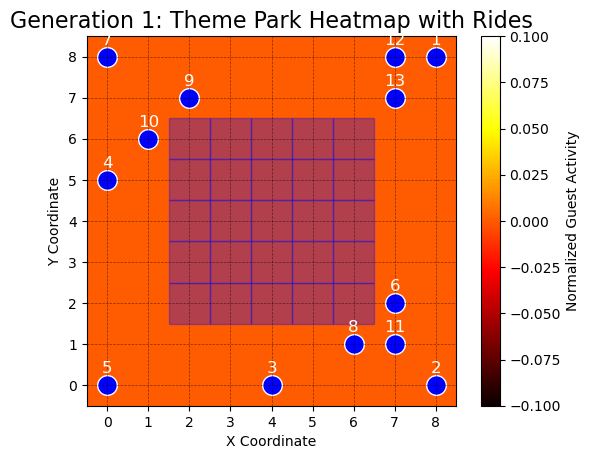

Best ride positions: [(6, (0, 8)), (0, (8, 8)), (11, (7, 8)), (12, (7, 7)), (3, (0, 5)), (8, (2, 7)), (10, (7, 1)), (4, (0, 0)), (1, (8, 0)), (5, (7, 2)), (7, (6, 1)), (9, (1, 6)), (2, (4, 0))]
Step: 0


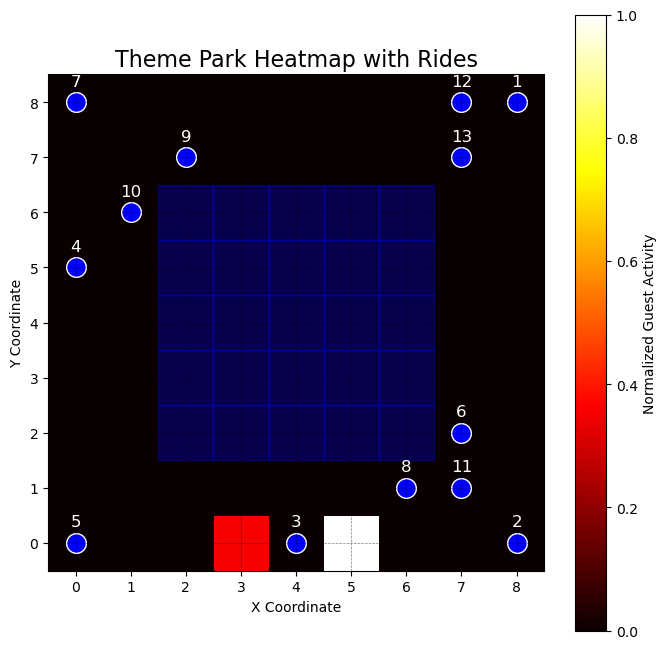

Step: 10


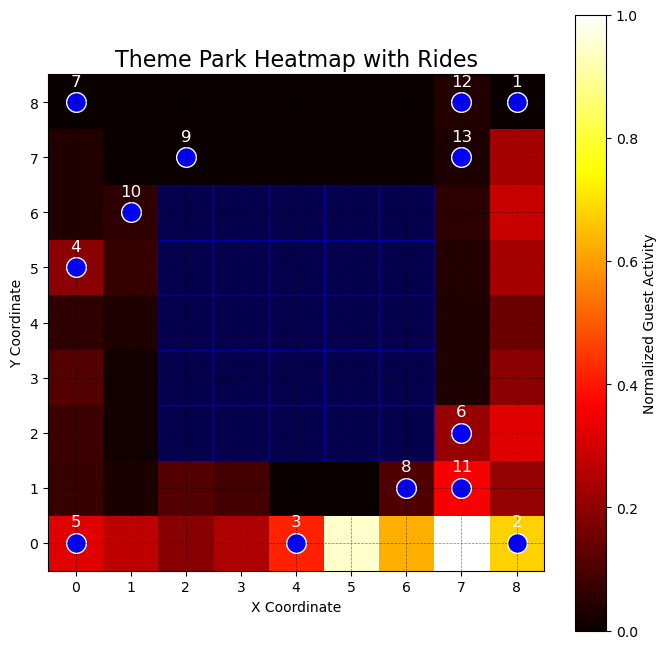

Step: 20


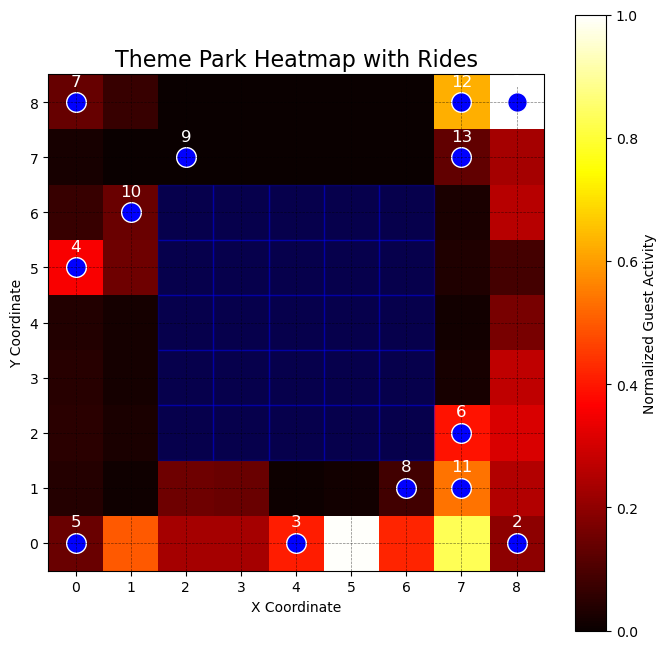

Step: 30


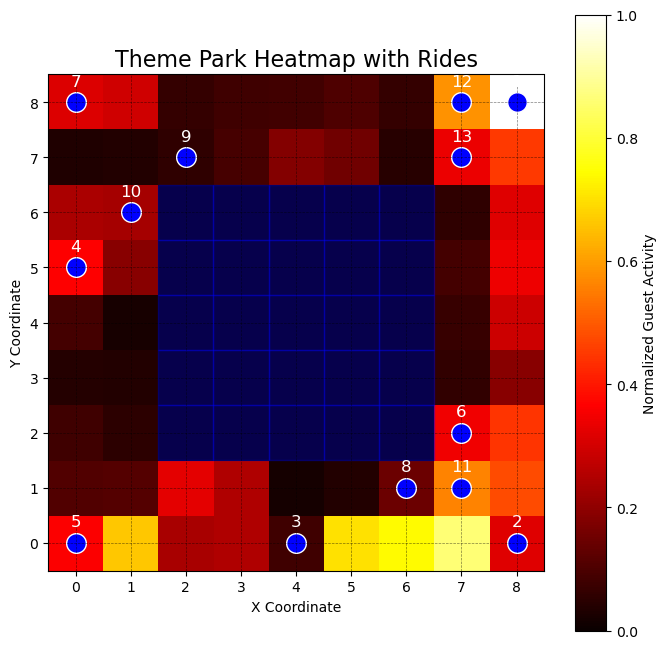

Step: 40


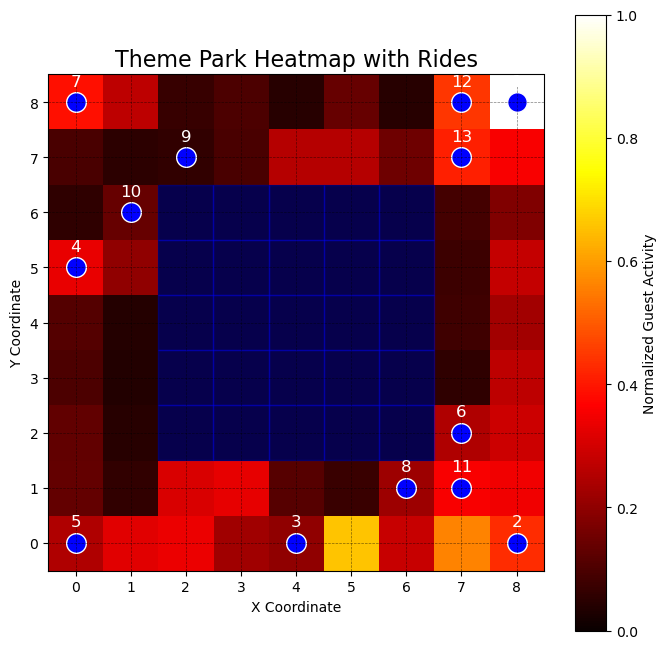

Step: 50


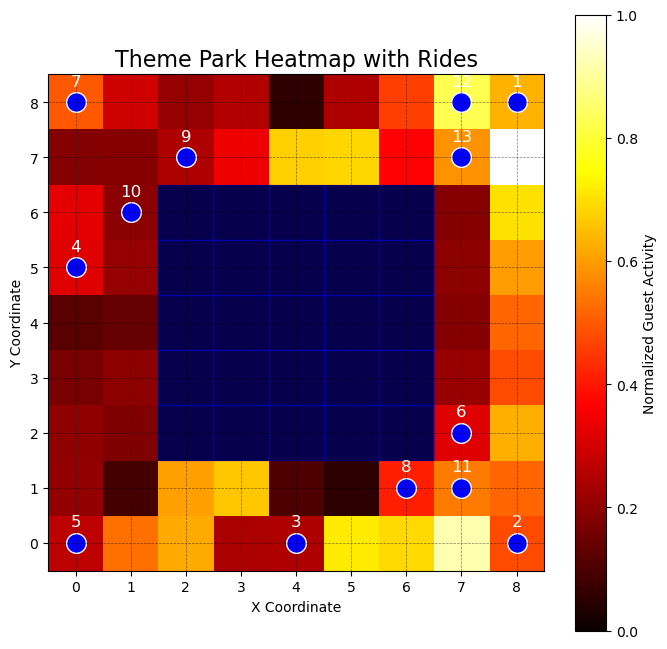

Step: 60


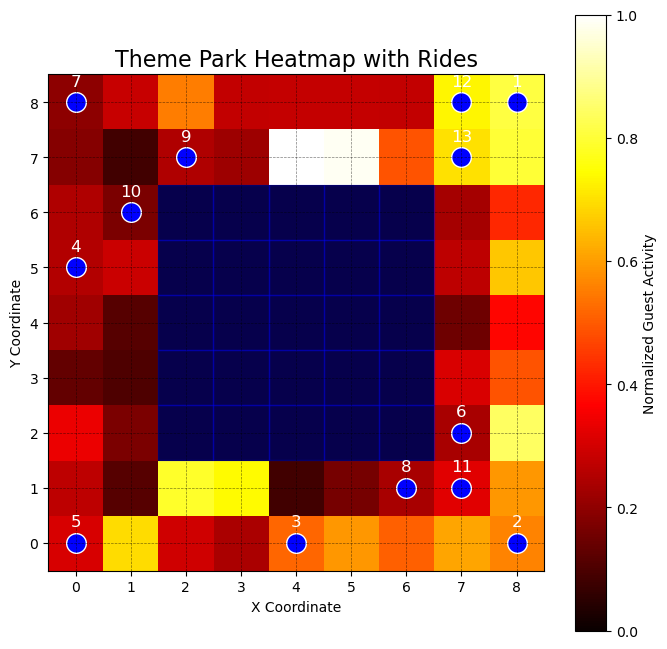

Step: 70


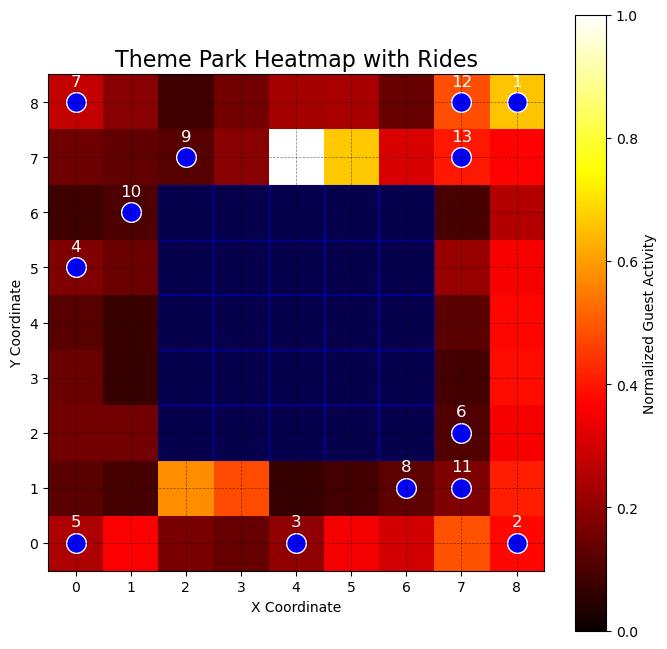

Step: 80


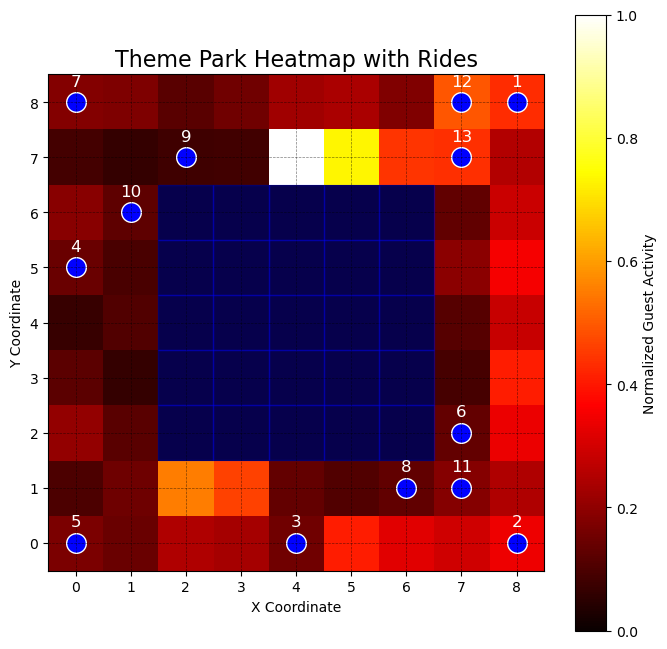

Step: 90


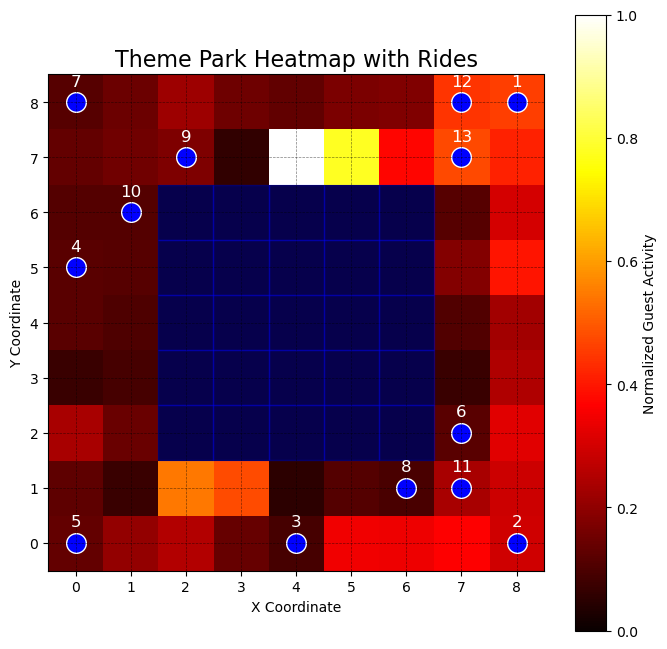

Step: 100


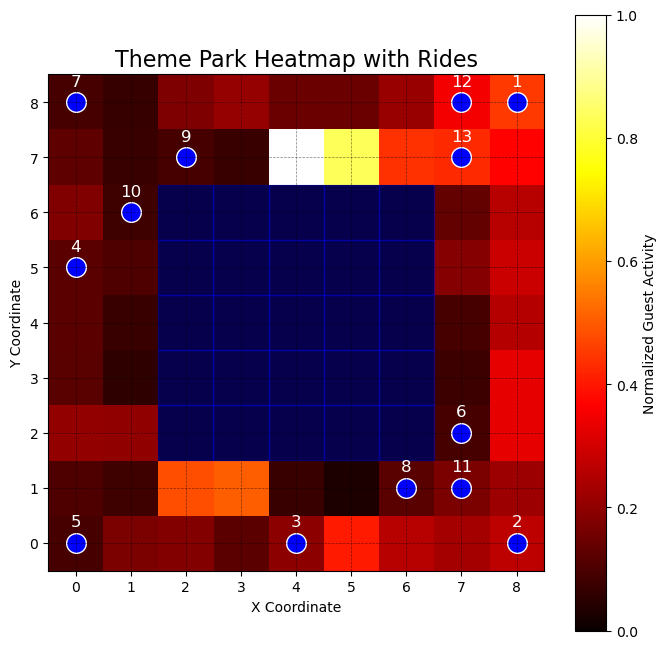

Step: 110


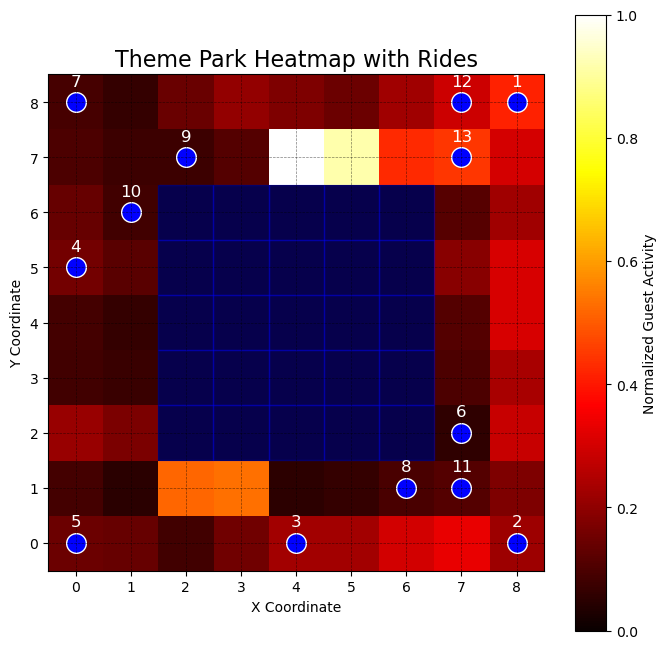

Step: 120


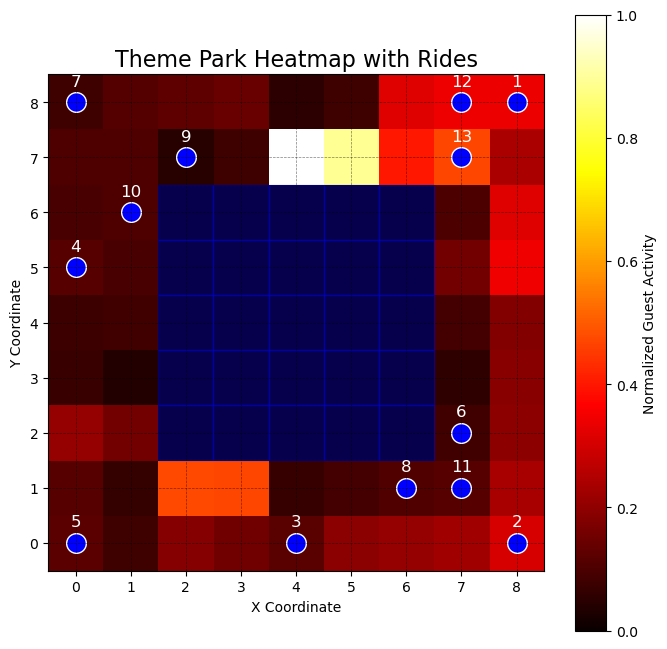

Step: 130


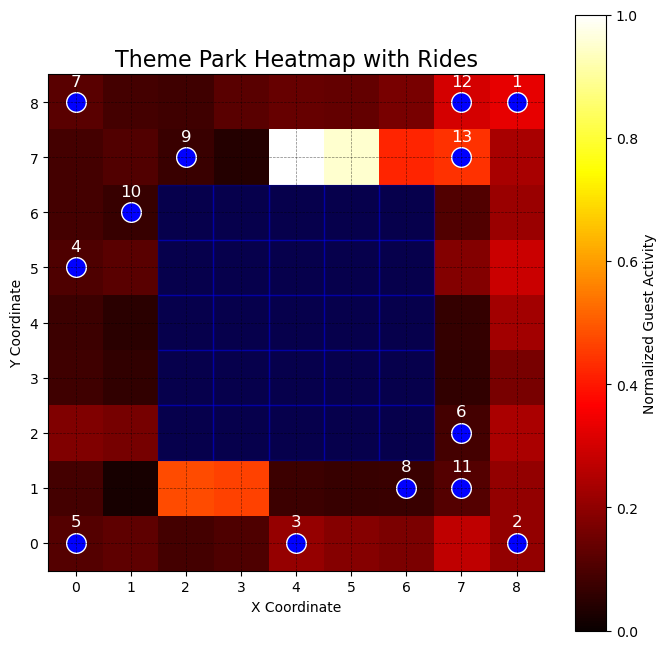

Step: 140


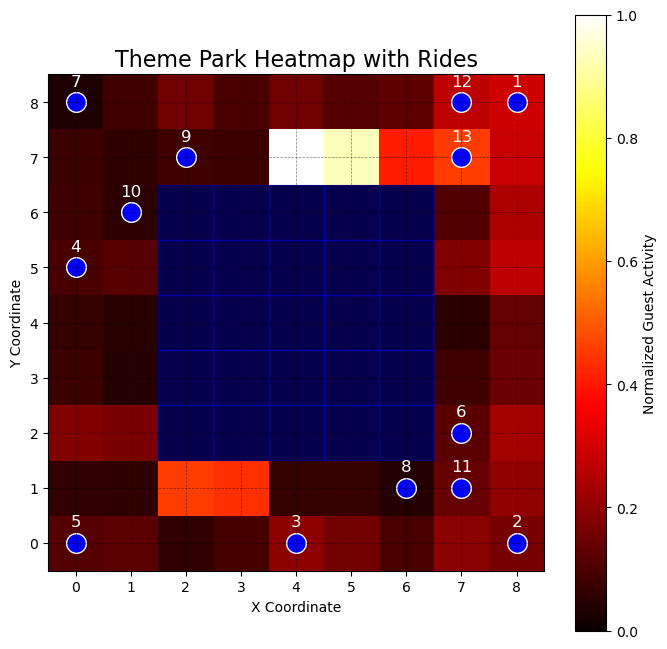

Step: 150


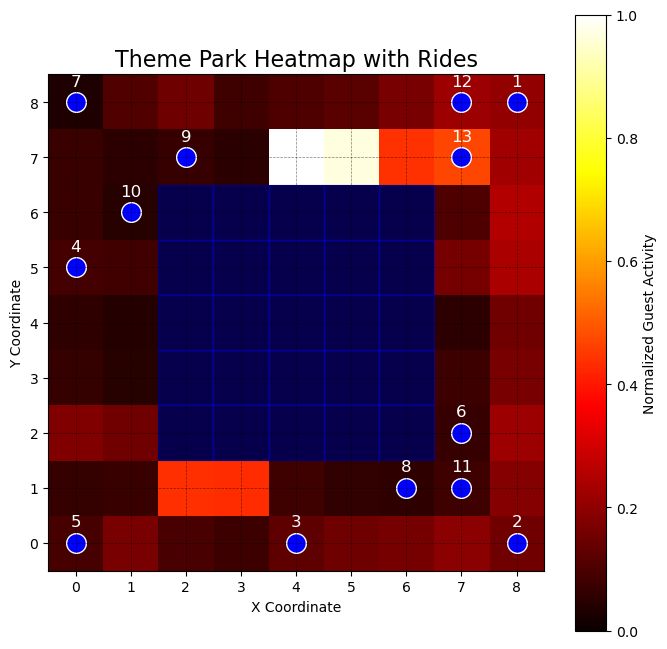

Step: 160


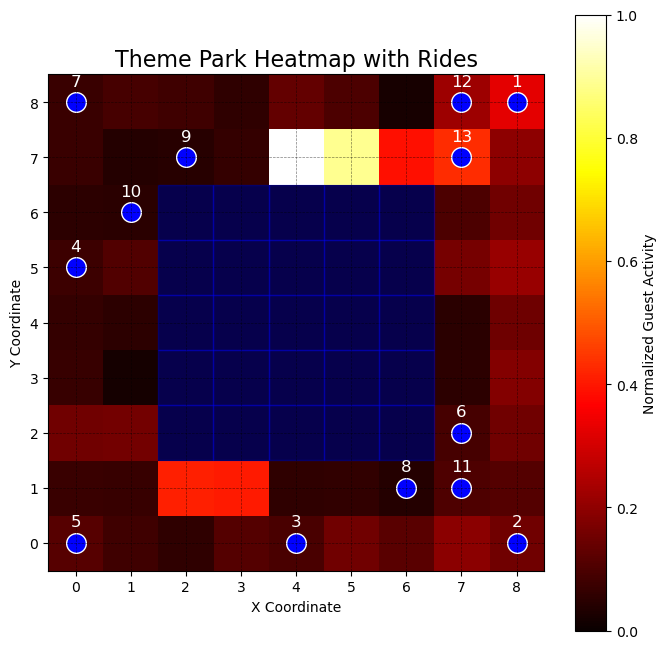

Step: 170


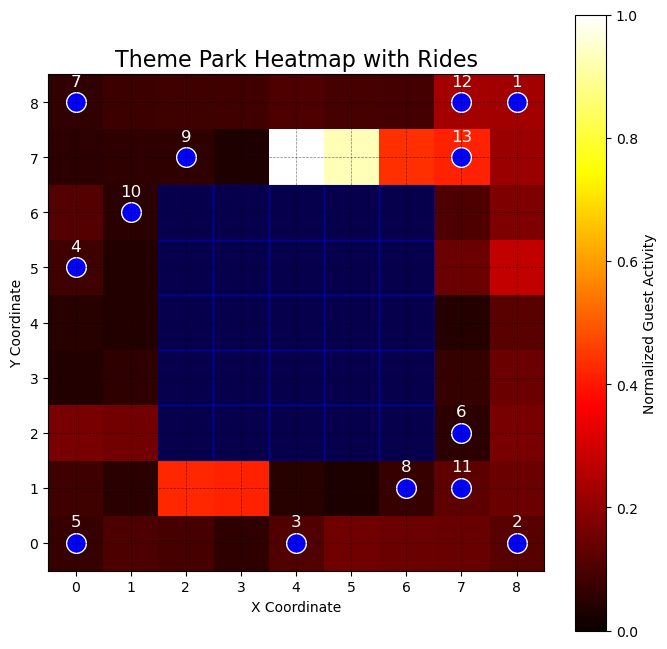

KeyboardInterrupt: 

In [86]:
#hemeParkGridModel(Model):def __init__(self, width, height, restricted_bottom_left=None, restricted_top_right=None, guest_inflow_type = None):
#each step 1 minute, 1km takes about 10mins, 1 sqaure is 50m(strolling) USS is 20ha roughly 100 x 100 is 1 ha 4 squares 1 ha, 80squares 20ha, guests spend on average 6 hours which is 360
ringmodel = ThemeParkGridModel(9,9,(2,2),(6,6))

# Define possible rides (from DataFrame or other source)
possible_rides = []

# Add rides dynamically from the DataFrame
for _, row in tivoli_attr_ranking.iterrows():
    # Add the ride with parameters from the DataFrame
    possible_rides.append({"name": row['Ranking'], "capacity": row['CAPACITY'], "service_time": random.randint(5, 10), "popularity_rank": row['Ranking']})

# Optimize ride placement
num_rides = len(tivoli_attr_ranking)  # Number of rides to include in the park

best_ride_positions = optimize_ride_placement(ringmodel, possible_rides, num_rides)

# Add the selected rides to the model
for ride_idx, pos in best_ride_positions:
    ride = possible_rides[ride_idx]
    ringmodel.add_ride(
        name=ride['name'],
        pos=pos,
        capacity=ride['capacity'],
        service_time=ride['service_time'],
        popularity_rank=ride['popularity_rank']
    )

# Print the best ride positions
print("Best ride positions:", best_ride_positions)

ringmodel = ThemeParkGridModel(9,9,(2,2),(6,6))

for i, position in enumerate(best_ride_positions):
    ride_idx = position[0]  # Get the ride index
    pos = position[1]  # Get the position (x, y)
    #print(pos)
    # Get the corresponding row from the DataFrame
    row = tivoli_attr_ranking.iloc[ride_idx]
    while True:        
        # Check if the position is not in the restricted area and not occupied by another ride
        if not ringmodel.is_restricted(*pos):  # Ensure the position is not in the restricted area
            # Check if the position is not occupied by another ride
            cell_contents = ringmodel.grid.get_cell_list_contents([pos])
            if not any(isinstance(agent, RideAgent) for agent in cell_contents):
                break  # Valid position found
    #print(f"here {i}")
    ringmodel.add_ride(
        name=row['Ranking'],  # Use the correct column name
        pos=position[1],
        capacity=row['CAPACITY'],
        service_time=random.randint(5, 10),
        popularity_rank=row['Ranking']
    )

for _ in range(540):  # Run for 50 steps
    ringmodel.step()
    if _ % 10 == 0:  # Plot every 5 steps
        print(f'Step: {_}')
        plot_combined_heatmap_and_rides_normalized(ringmodel)
